In [1]:
import os
import json
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import StringLookup
from nltk.metrics.distance import edit_distance
from tqdm import tqdm


In [2]:
# Define the data directory path
data_dir = "TextOCR"
annotation_file = os.path.join(data_dir, "TextOCR_0.1_train.json")
train_image_dir = os.path.join(data_dir, "train_val_images", "train_images")

In [3]:
# Load JSON annotation data
with open(annotation_file, "r") as f:
    data = json.load(f)

In [4]:
# Load image information from json file
img_data = data["imgs"]

In [5]:
# Load annotations and filter for images in the JSON
df = pd.read_csv(os.path.join(data_dir, "annot.csv"))
df = df[df["image_id"].isin(img_data.keys())]

num_images = df.shape[0]
print("Number of images in the dataset:", num_images)

Number of images in the dataset: 1052354


In [6]:
sample_size = 1000  # Adjust this value as needed
df_sample = df.sample(n=sample_size, random_state=42)  # Seed for reproducibility

In [7]:
# images = []
# labels = []
# for _, row in df_sample.iterrows():  # Iterate over the sample

#     img_path = os.path.join(train_image_dir, row["image_id"] + ".jpg")
#     image = cv2.imread(img_path)
#     if image is None:
#         continue  # Skip if the image cannot be loaded
#     bbox = eval(row["bbox"])
#     x_min, y_min, width, height = map(int, bbox)

#     cropped_img = image[y_min : y_min + height, x_min : x_min + width]
#     cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)

#     # Resize the image while keeping the aspect ratio
#     height = 32
#     aspect_ratio = cropped_img.shape[1] / cropped_img.shape[0]
#     width = int(height * aspect_ratio)
#     cropped_img = cv2.resize(cropped_img, (width, height)) / 255.0

#     # Pad the image to ensure it has a fixed width
#     padded_img = np.zeros((32, 128))
#     if width <= 128:
#         padded_img[:, :width] = cropped_img
#     else:
#         padded_img = cv2.resize(cropped_img, (128, 32))

#     images.append(padded_img)

#     labels.append(row["utf8_string"])

In [8]:
images = []
labels = []
skipped_images = []  # List to track skipped images

for _, row in tqdm(
    df_sample.iterrows(), total=len(df_sample), desc="Processing images"
):  # Using tqdm for progress bar
    img_path = os.path.join(train_image_dir, row["image_id"] + ".jpg")
    image = cv2.imread(img_path)

    if image is None:
        print(f"Skipping image {row['image_id']}: Unable to load image.")
        skipped_images.append(row["image_id"])
        continue

    bbox = eval(row["bbox"])
    x_min, y_min, width, height = map(int, bbox)
    label = row["utf8_string"]

    # Additional Check for Empty or Invalid Labels
    if not label or not isinstance(label, str):
        print(f"Skipping image {row['image_id']}: Empty or invalid label.")
        skipped_images.append(row["image_id"])
        continue

    cropped_img = image[y_min : y_min + height, x_min : x_min + width]
    cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)

    # Resize the image while keeping the aspect ratio
    height = 32
    aspect_ratio = cropped_img.shape[1] / cropped_img.shape[0]
    width = int(height * aspect_ratio)
    cropped_img = cv2.resize(cropped_img, (width, height)) / 255.0

    # Pad the image to ensure it has a fixed width
    padded_img = np.zeros((32, 128))
    if width <= 128:
        padded_img[:, :width] = cropped_img
    else:
        padded_img = cv2.resize(cropped_img, (128, 32))

    images.append(padded_img)

    labels.append(row["utf8_string"])

Processing images:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing images: 100%|██████████| 1000/1000 [00:05<00:00, 187.24it/s]


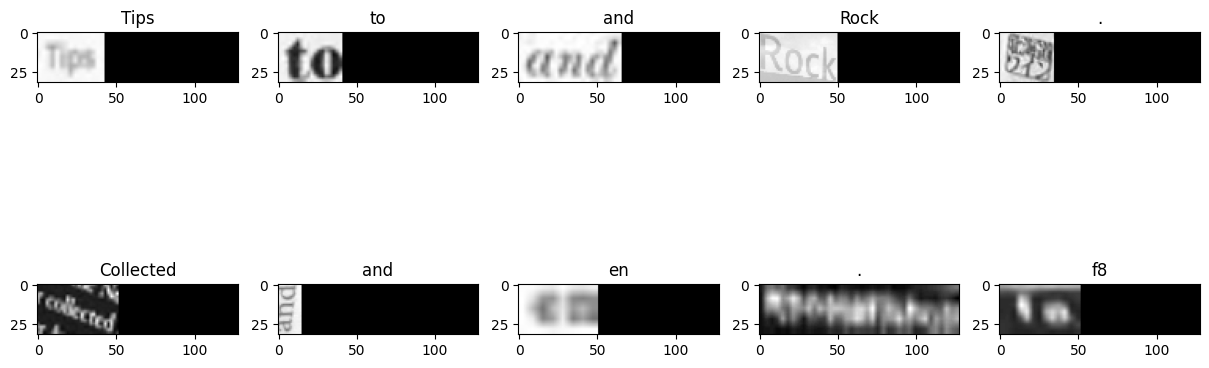

In [9]:
# Display some images (for verification)
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, img in enumerate(images[:10]):
    row = i // 5
    col = i % 5
    axs[row, col].imshow(img, cmap="gray")
    axs[row, col].set_title(labels[i])
plt.show()

In [10]:
# Convert image list to numpy array for efficient processing
images = np.array(images)

In [11]:
print(type(labels))
print(labels[3000:])  # Print the first 5 elements

<class 'list'>
[]


In [12]:
import string

# Define the set of allowed characters
allowed_chars = set(string.ascii_letters + string.digits + string.punctuation)

# Create character vocabulary
chars = set()
for label in labels:
    if isinstance(label, str) and label is not None:
        chars.update(
            c for c in label if c in allowed_chars
        )  # Only add allowed characters
chars = sorted(list(chars))

print(chars)  # Print the refined character vocabulary to verify

['!', '"', '#', '$', '%', '&', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', '^', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [13]:
# Mapping characters to integers
char_to_num = StringLookup(vocabulary=list(chars), mask_token=None)

# Mapping integers back to original characters
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [14]:
filtered_labels = [
    label for label in labels if isinstance(label, str) and label is not None
]

In [15]:
# Encode the labels
encoded_labels = [
    char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8")).numpy()
    for label in filtered_labels
]

# Find maximum length and pad the labels to that size
max_label_length = max(len(label) for label in encoded_labels)
padded_labels = tf.keras.preprocessing.sequence.pad_sequences(
    encoded_labels, maxlen=max_label_length, padding="post", value=len(chars)
)

print(padded_labels)

[[48 66 73 ... 83 83 83]
 [77 72 83 ... 83 83 83]
 [58 71 61 ... 83 83 83]
 ...
 [12 83 83 ... 83 83 83]
 [28 83 83 ... 83 83 83]
 [12 83 83 ... 83 83 83]]


In [16]:
num_images = len(images)
num_labels = len(padded_labels)

print("Number of images:", num_images)
print("Number of labels:", num_labels)

Number of images: 1000
Number of labels: 1000


In [17]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(
    images, padded_labels, test_size=0.2, random_state=42
)

In [18]:
# Define input shape (height, width, channels) - for variable width
input_shape = (32, None, 1)

In [19]:
num_classes = len(chars) + 1

In [20]:
def build_crnn_model(input_shape, num_classes):
    model = keras.Sequential()

    # Convolutional Layers
    model.add(
        layers.Conv2D(
            64, (3, 3), activation="relu", input_shape=input_shape, padding="same"
        )
    )
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding="same"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation="relu", padding="same"))
    model.add(layers.Conv2D(256, (3, 3), activation="relu", padding="same"))
    model.add(layers.MaxPooling2D(pool_size=(1, 2)))
    model.add(layers.Conv2D(512, (3, 3), activation="relu", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(512, (3, 3), activation="relu", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(1, 2)))

    # Reshape to prepare for LSTM layers
    model.add(layers.Reshape((-1, 512)))

    # Recurrent Layers (LSTM)
    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
    # model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True))) # Modified line

    # Output Layer (Dense)
    model.add(layers.Dense(num_classes))
    return model

In [21]:
model = build_crnn_model(input_shape, num_classes)

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Define CTC loss function with input_length and label_length parameters
def ctc_loss(y_true, y_pred, input_length, label_length):
    # Ensure labels are of type int32
    y_true = tf.cast(y_true, tf.int32)

    # Calculate the CTC loss
    loss = tf.nn.ctc_loss(
        labels=y_true,
        logits=y_pred,
        label_length=label_length,
        logit_length=input_length,
        blank_index=len(chars),
    )
    return tf.reduce_mean(loss)

In [23]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9
)

In [24]:
model.compile(
    loss=ctc_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule)
)

In [25]:
# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, None, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, None, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, None, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, None, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, None, 256)   │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, None, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, None, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, None, 512)   │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, None, 512)   │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, None, 512)   │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, None, 512)   │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, None, 512)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 256)      │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 84)       │        21,588 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,181,780 (19.77 MB)

 Trainable params: 5,179,732 (19.76 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [26]:
print("x_train shape:", x_train.shape)
print("x_valid shape:", x_valid.shape)

x_train shape: (800, 32, 128)
x_valid shape: (200, 32, 128)


In [27]:
def train_batch(x_train, y_train):
    input_length = (
        tf.ones(tf.shape(y_train)[0], dtype=tf.int32) * tf.shape(x_train)[1] // 2
    )  # //2 maxpool downsampling
    label_length = tf.reduce_sum(
        tf.cast(tf.math.not_equal(y_train, len(chars)), tf.int32), axis=-1
    )

    # Pass input_length and label_length to the ctc_loss function
    with tf.GradientTape() as tape:
        y_pred = model(x_train, training=True)
        loss = ctc_loss(y_train, y_pred, input_length, label_length)

    # Get the gradients and apply them
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss.numpy()  # Convert to numpy


for epoch in range(10):
    print("Epoch", epoch + 1, "/", 10)
    train_loss = []
    for batch in tqdm(
        range(len(x_train) // 64), desc=f"Training epoch {epoch+1}"
    ):  # Added tqdm here
        index = batch * 64
        x = x_train[index : index + 64]
        y = y_train[index : index + 64]
        batch_loss = train_batch(x, y)
        train_loss.append(batch_loss)
    print("Epoch:", epoch + 1, "Loss:", np.mean(train_loss))

Epoch 1 / 10


Training epoch 1: 100%|██████████| 12/12 [00:23<00:00,  1.95s/it]


Epoch: 1 Loss: 27.566114
Epoch 2 / 10


Training epoch 2: 100%|██████████| 12/12 [00:22<00:00,  1.90s/it]


Epoch: 2 Loss: 16.806463
Epoch 3 / 10


Training epoch 3: 100%|██████████| 12/12 [00:23<00:00,  1.97s/it]


Epoch: 3 Loss: 16.254946
Epoch 4 / 10


Training epoch 4: 100%|██████████| 12/12 [00:22<00:00,  1.84s/it]


Epoch: 4 Loss: 15.995828
Epoch 5 / 10


Training epoch 5: 100%|██████████| 12/12 [00:25<00:00,  2.09s/it]


Epoch: 5 Loss: 15.8652725
Epoch 6 / 10


Training epoch 6: 100%|██████████| 12/12 [00:23<00:00,  1.97s/it]


Epoch: 6 Loss: 15.798619
Epoch 7 / 10


Training epoch 7: 100%|██████████| 12/12 [00:24<00:00,  2.04s/it]


Epoch: 7 Loss: 15.741791
Epoch 8 / 10


Training epoch 8: 100%|██████████| 12/12 [00:24<00:00,  2.01s/it]


Epoch: 8 Loss: 15.667666
Epoch 9 / 10


Training epoch 9: 100%|██████████| 12/12 [00:22<00:00,  1.91s/it]


Epoch: 9 Loss: 15.59013
Epoch 10 / 10


Training epoch 10: 100%|██████████| 12/12 [00:23<00:00,  1.94s/it]

Epoch: 10 Loss: 15.511092


In [28]:
model.save("my_model1.keras")  # or keras.saving.save_model(model, 'my_model.keras')

In [29]:
def preprocess_image(image_path):
    """Loads and preprocesses an image for model prediction."""
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale directly
    if image is None:
        raise ValueError("Image could not be loaded.")

    # Preprocessing for contour detection
    blurred = cv2.GaussianBlur(image, (5, 5), 0)  # Blur the grayscale image
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 4)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter and extract bounding boxes
    bounding_boxes = []
    for contour in contours:
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)

        # Filter based on area and aspect ratio 
        if 100 < area < 5000 and (0.2 < w / h < 10):  # Adjust thresholds as needed
            bounding_boxes.append([x, y, w, h])

    # Preprocess each detected region
    processed_images = []
    for bbox in bounding_boxes:
        x_min, y_min, width, height = map(int, bbox)
        cropped_img = image[y_min:y_min + height, x_min:x_min + width]  # Crop from the grayscale image

        # Resize while keeping aspect ratio
        height = 32
        aspect_ratio = cropped_img.shape[1] / cropped_img.shape[0]
        width = min(int(height * aspect_ratio), 128)  # Limit width to 128
        cropped_img = cv2.resize(cropped_img, (width, height)) / 255.0  # Normalize to 0-1

        # Pad to a fixed width
        padded_img = np.zeros((32, 128))
        padded_img[:, :width] = cropped_img

        processed_images.append(padded_img)
    
    return processed_images, bounding_boxes  # Return both images and boxes


In [30]:
def predict_text(image_path, model, char_to_num, num_to_char):
    """Predicts text from a given image path and displays the padded image."""
    processed_images, _ = preprocess_image(image_path)  # Ignore bounding boxes for now

    predicted_texts = []
    for img in processed_images:
        img = np.expand_dims(img, axis=0)  # Add batch dimension

        # Display the padded image
        plt.figure(figsize=(5, 1))  # Adjust figsize as needed
        plt.imshow(img[0], cmap='gray')
        plt.title("Padded Image")
        plt.show()

        prediction = model.predict(img)

        # Decode the prediction
        decoded_prediction = tf.keras.backend.ctc_decode(prediction, input_length=np.ones(prediction.shape[0]) * prediction.shape[1], greedy=True)[0][0]
        predicted_text = tf.strings.reduce_join(num_to_char(decoded_prediction)).numpy().decode("utf-8")
        predicted_texts.append(predicted_text)

    return predicted_texts

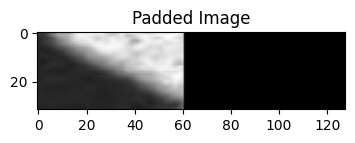

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


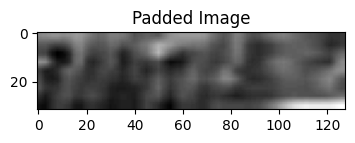

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


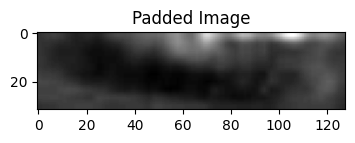

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


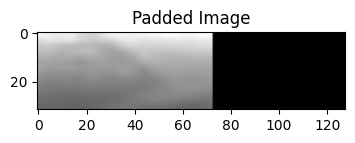

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


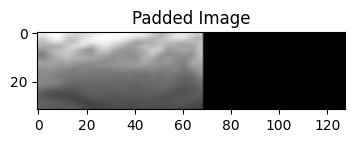

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


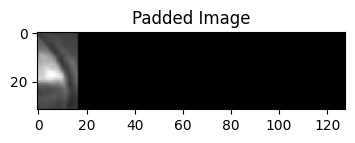

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


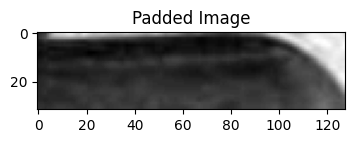

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


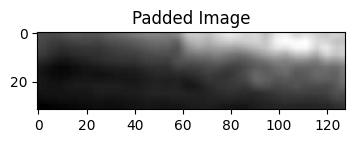

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


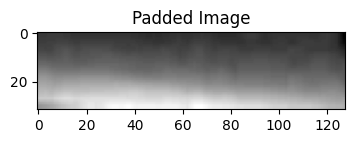

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


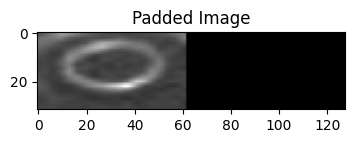

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


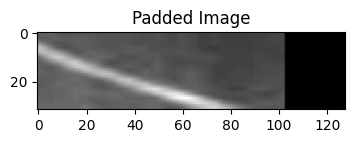

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


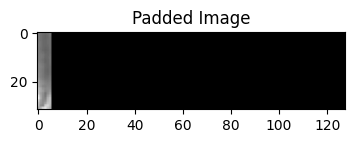

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


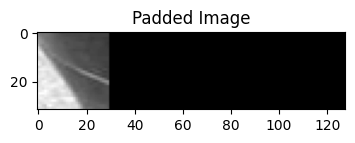

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


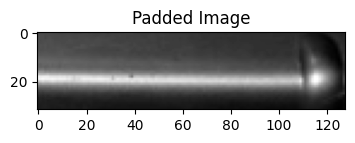

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


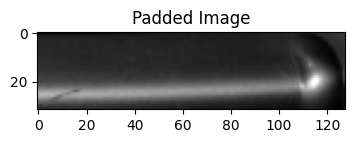

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


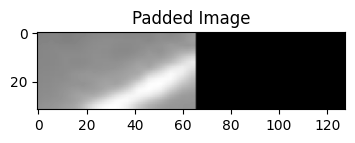

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


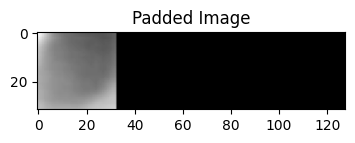

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


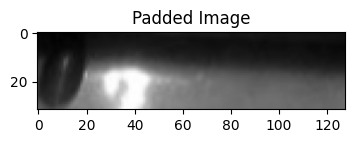

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


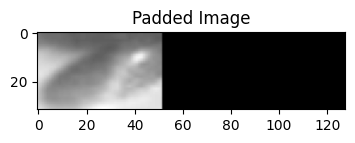

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


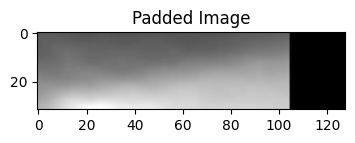

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


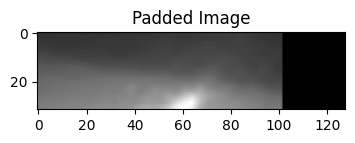

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


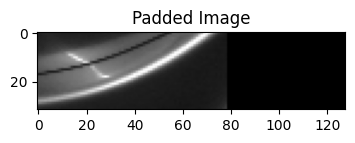

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


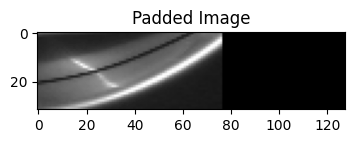

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


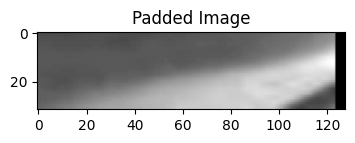

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


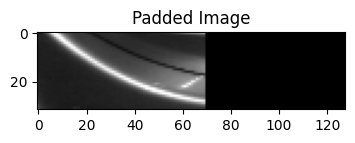

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


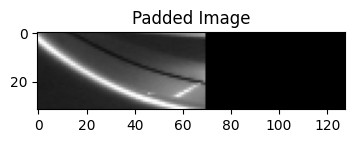

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


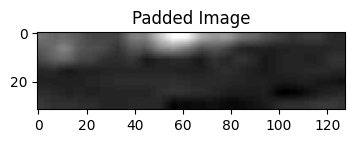

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


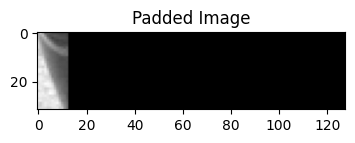

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


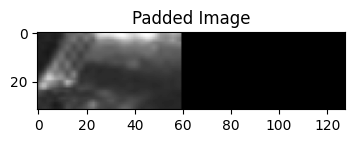

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


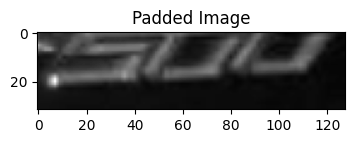

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


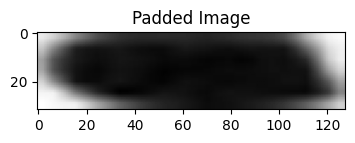

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


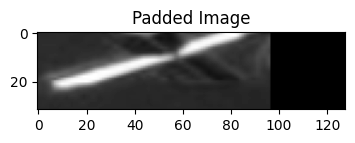

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


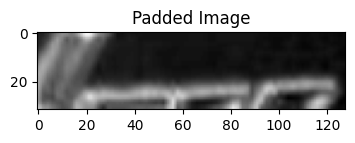

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


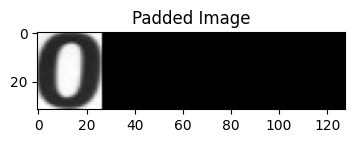

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


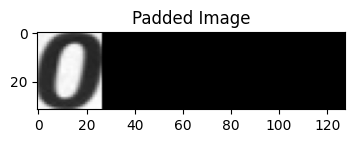

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


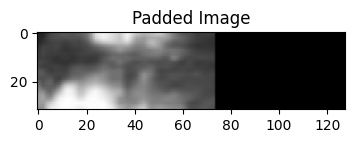

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


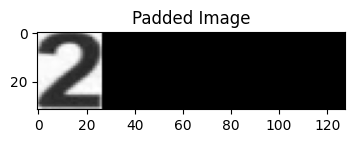

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


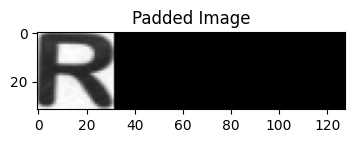

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


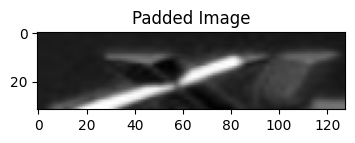

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


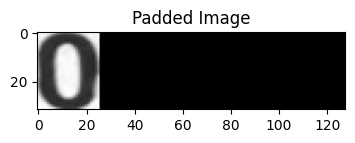

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


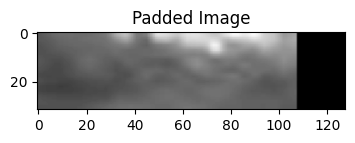

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


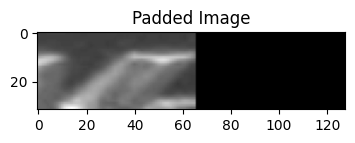

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


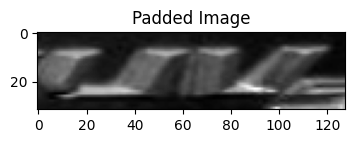

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


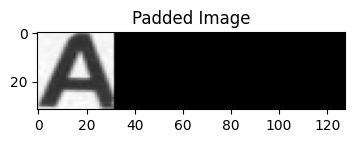

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


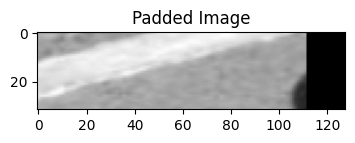

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


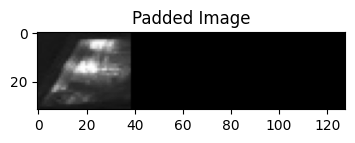

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


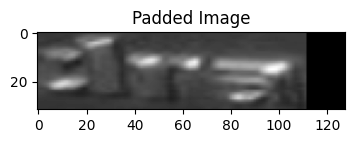

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


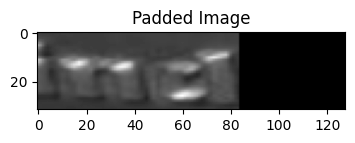

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


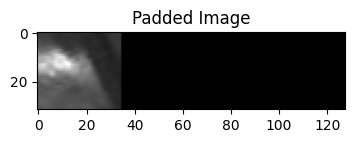

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


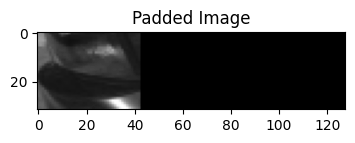

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


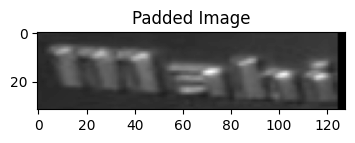

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


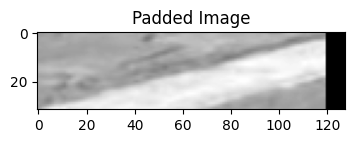

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


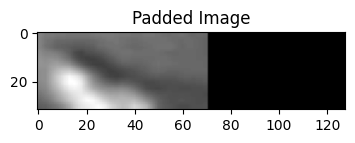

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


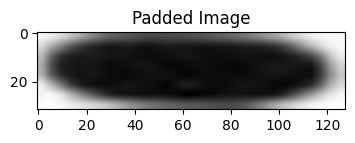

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


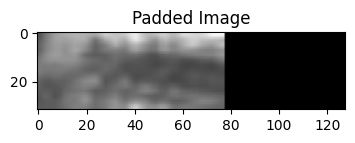

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


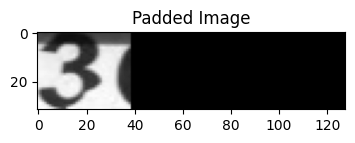

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


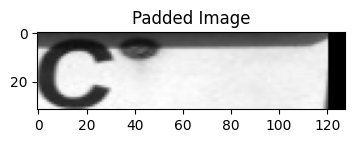

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


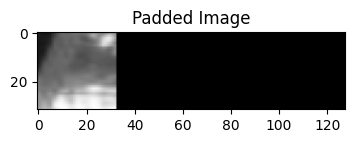

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


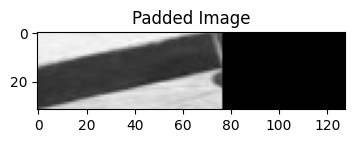

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


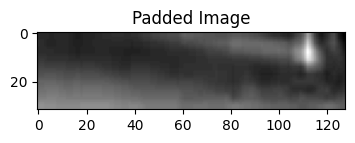

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


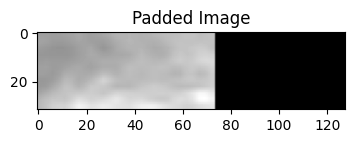

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


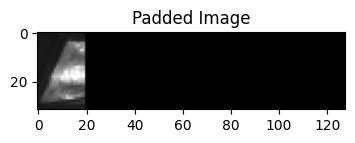

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


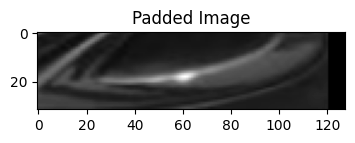

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


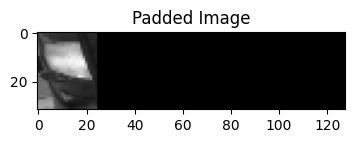

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


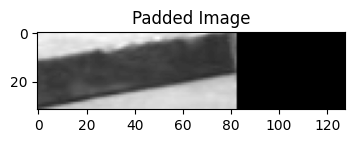

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


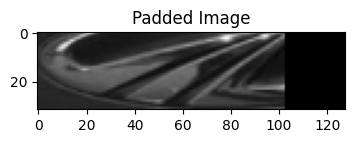

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


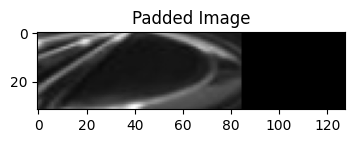

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


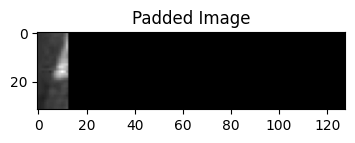

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


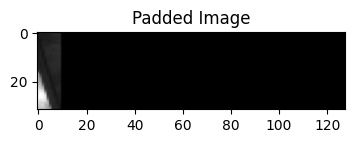

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


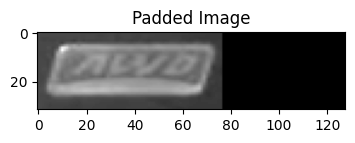

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


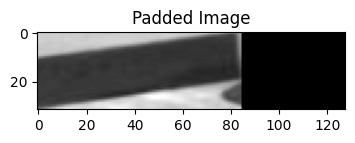

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


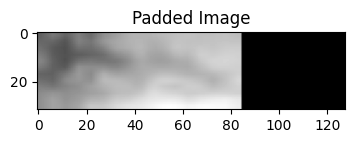

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


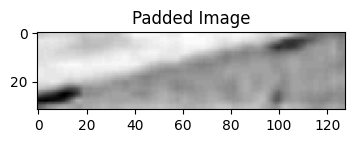

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


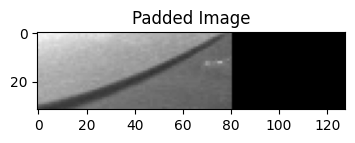

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


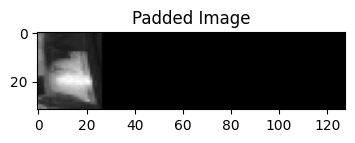

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


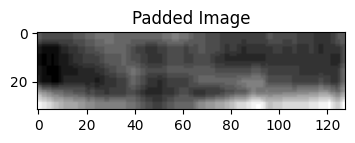

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


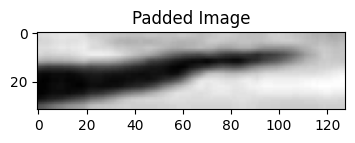

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


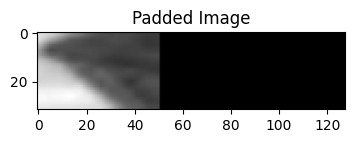

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


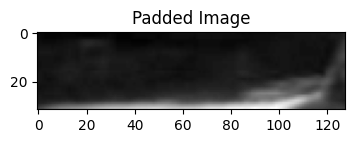

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


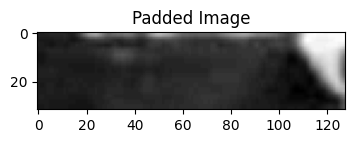

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


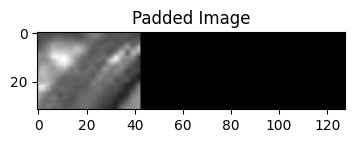

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


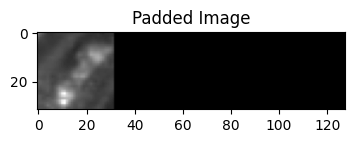

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


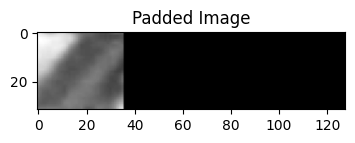

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


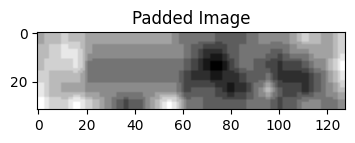

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


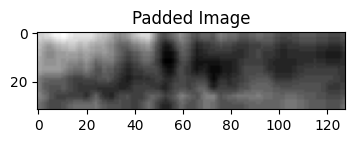

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


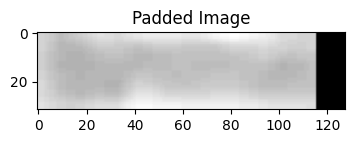

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


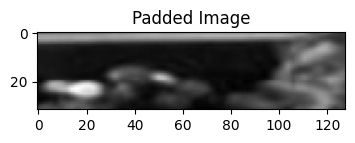

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


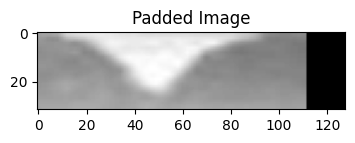

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


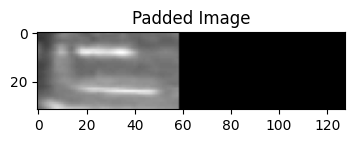

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


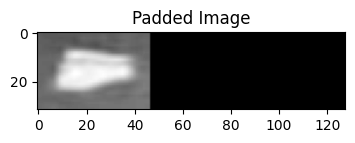

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


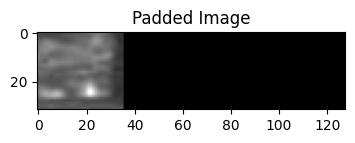

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


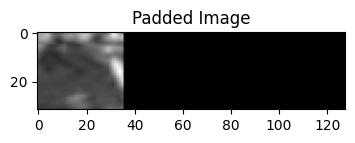

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


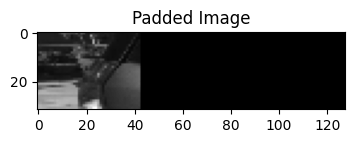

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


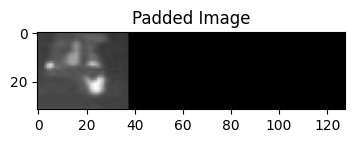

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


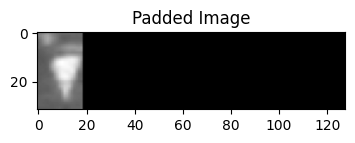

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


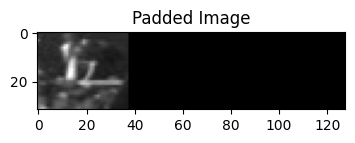

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


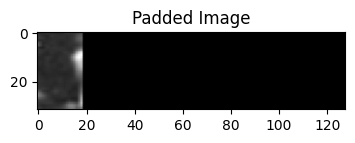

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


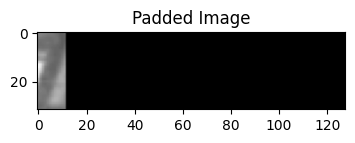

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


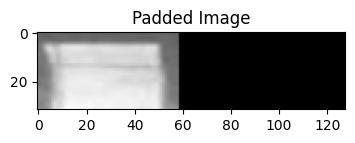

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


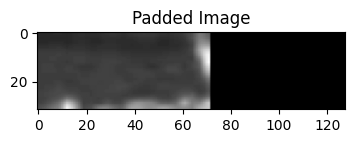

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


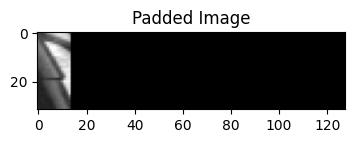

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


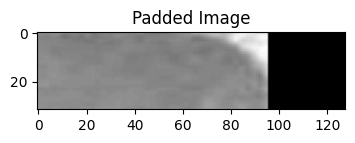

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


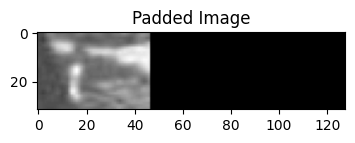

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Extracted text: ['[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]', '[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]', '[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][

In [31]:
# Example usage
loaded_model = keras.models.load_model('my_model.keras', custom_objects={'ctc_loss': ctc_loss})
image_path = '/Users/lalit/Documents/OCR PROJECT/image.png'
predicted_texts = predict_text(image_path, loaded_model, char_to_num, num_to_char)
# Print the extracted text
print("Extracted text:", predicted_texts)
